In [2]:
# 1. Import Required Libraries
import os
import shutil
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
# 2. Prepare Dataset Paths
original_data_dir = 'dataset'  # Path to downloaded dataset
base_dir = 'data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [4]:
# 3. Split Dataset (if not already split)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
split_ratio = 0.8

for class_name in os.listdir(original_data_dir):
    class_path = os.path.join(original_data_dir, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        random.shuffle(images)
        split_index = int(len(images) * split_ratio)

        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)

        for img in tqdm(images[:split_index], desc=f'Training - {class_name}'):
            shutil.copy(os.path.join(class_path, img), os.path.join(train_class_dir, img))
        for img in tqdm(images[split_index:], desc=f'Validation - {class_name}'):
            shutil.copy(os.path.join(class_path, img), os.path.join(val_class_dir, img))

Validation - Cherry___Powdery_mildew: 100%|██████████| 211/211 [00:03<00:00, 63.77it/s]
Training - Corn___Cercospora_leaf_spot Gray_leaf_spot: 100%|██████████| 410/410 [00:06<00:00, 63.74it/s]
Validation - Corn___Cercospora_leaf_spot Gray_leaf_spot: 100%|██████████| 103/103 [00:01<00:00, 54.57it/s]
Validation - Grape___healthy: 100%|██████████| 85/85 [00:01<00:00, 60.07it/s]
Training - Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 100%|██████████| 860/860 [00:14<00:00, 58.51it/s]
Validation - Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 100%|██████████| 216/216 [00:03<00:00, 60.48it/s]
Training - Orange___Haunglongbing_(Citrus_greening): 100%|██████████| 4405/4405 [01:17<00:00, 56.82it/s]
Validation - Orange___Haunglongbing_(Citrus_greening): 100%|██████████| 1102/1102 [00:20<00:00, 52.82it/s]
Validation - Tomato___Septoria_leaf_spot: 100%|██████████| 355/355 [00:04<00:00, 72.34it/s]
Training - Tomato___Spider_mites Two-spotted_spider_mite: 100%|██████████| 1340/1340 [00:21<00:00, 63.45it

In [5]:
# 4. Data Preprocessing
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 44343 images belonging to 39 classes.
Found 11105 images belonging to 39 classes.


In [6]:
# 5. Build Model with MobileNetV2
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


9412608/9406464 [==============================] - 1s 0us/step


In [7]:
# 6. Train Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
1386/1386 [==============================] - 3148s 2s/step - loss: 0.6722 - accuracy: 0.8017 - val_loss: 0.2869 - val_accuracy: 0.9083
Epoch 2/10
1386/1386 [==============================] - 2622s 2s/step - loss: 0.3555 - accuracy: 0.8833 - val_loss: 0.2260 - val_accuracy: 0.9268
Epoch 3/10
1386/1386 [==============================] - 2604s 2s/step - loss: 0.3079 - accuracy: 0.8991 - val_loss: 0.2348 - val_accuracy: 0.9194
Epoch 4/10
1386/1386 [==============================] - 2643s 2s/step - loss: 0.2884 - accuracy: 0.9040 - val_loss: 0.2080 - val_accuracy: 0.9295
Epoch 5/10
1386/1386 [==============================] - 2619s 2s/step - loss: 0.2754 - accuracy: 0.9076 - val_loss: 0.1828 - val_accuracy: 0.9365
Epoch 6/10
1386/1386 [==============================] - 2638s 2s/step - loss: 0.2663 - accuracy: 0.9110 - val_loss: 0.1790 - val_accuracy: 0.9405
Epoch 7/10
1386/1386 [==============================] - 2599s 2s/step - loss: 0.2597 - accuracy: 0.9136 - val_loss: 0.1756 -

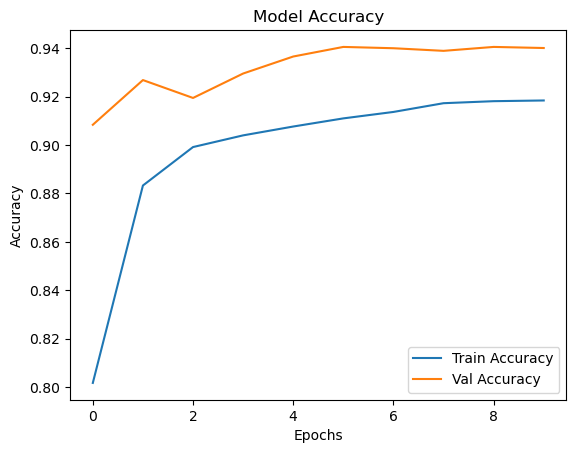

In [8]:
# 7. Evaluate Model
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.01      0.01      0.01       126
                            Apple___Black_rot       0.02      0.02      0.02       125
                     Apple___Cedar_apple_rust       0.00      0.00      0.00        55
                              Apple___healthy       0.04      0.04      0.04       329
                    Background_without_leaves       0.02      0.02      0.02       229
                          Blueberry___healthy       0.01      0.01      0.01       301
                      Cherry___Powdery_mildew       0.02      0.02      0.02       211
                             Cherry___healthy       0.03      0.04      0.03       171
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00       103
                           Corn___Common_rust       0.03      0.03      0.03       239
                  Corn___Northern_Leaf_Bli

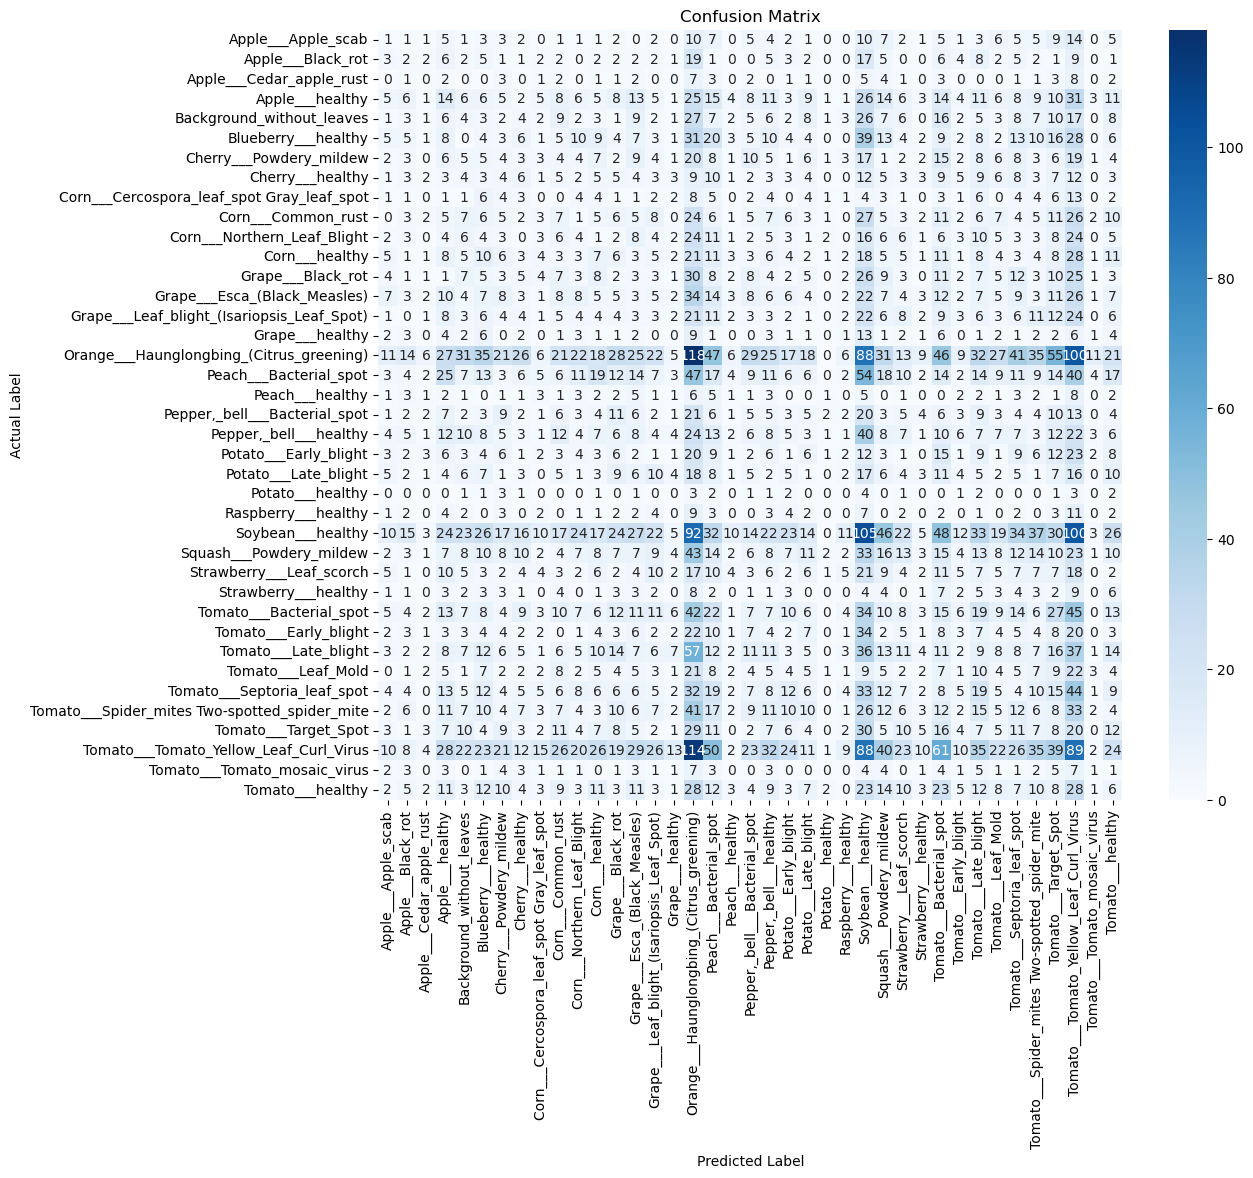

In [9]:
# 8. Confusion Matrix and Report
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=val_generator.class_indices.keys()))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


In [10]:
# 9. Save Model
model.save('plant_disease_model_plantvillage.h5')


In [1]:
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('model.h5')

# Show model summary to inspect the output layer
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

# Replace with your actual training directory
train_generator = datagen.flow_from_directory('dataset')

# This gives you the class labels in the correct order
class_labels = list(train_generator.class_indices.keys())
print("Class labels:", class_labels)


Found 55448 images belonging to 39 classes.
Class labels: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',

In [6]:
import json

# Save class labels to a JSON file
class_labels = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']  # Use your actual class order
with open("class_labels.json", "w") as f:
    json.dump(class_labels, f)

print("Class labels saved to class_labels.json")


Class labels saved to class_labels.json
